In [12]:
import numpy
from finance_utils.asset.spot.base import Spot
from finance_utils.process.prices.gbm import RVDecoupledGBM, GBM, NormalDistribution
from finance_utils.trader.base import Trader
from matplotlib import pyplot

from data_utils.stochastic_utils.distributions.nonParametricDistribution import HistogramDist
from easy_datetime.timestamp import TimeStamp
import tqdm

from matplotlib import pyplot

In [13]:
base_trader = Trader("trader", 20000 * 12, "2000-1-1")
s1_trader = Trader("s1_trader", 20000 * 12, "2000-1-1")
s2_trader = Trader("s2_trader", 20000 * 12, "2000-1-1")

In [14]:
stock = Spot("10001", 100, ["day", 1])

In [15]:
stock_process = GBM(stock.name, 100, 0.03/12, 0.08, 12, "2024-1-1", "month", 1)
multi_pathing = stock_process.multi_pathing(base_trader, stock, 1000)

In [16]:
asset_yield_list = []
base_trader_yield_list = []
for i,t in enumerate(multi_pathing.timeline):
    t:TimeStamp
    price_slice = []
    yield_slice = []
    for j in range(multi_pathing.size[1]):
        path_value = multi_pathing.processes[j].get_price(t)
        stock.purchased_to(multi_pathing.trades[j], path_value.price, 20000, t)
        yield_slice.append(multi_pathing.trades[j].net_worth_rate(**path_value.dic))
        price_slice.append(path_value.price / 100)
    base_trader_yield_list.append(yield_slice)
    asset_yield_list.append(price_slice)
    
    
    # if t.day % 2 == 1:
    #     for j in range(multi_pathing.size[1]):
    #         path_value = multi_pathing.processes[j].get_price(t)
    #         stock.purchased_to(multi_pathing.trades[j], path_value.price, 20000, t)
    # elif t.day == t.last_day_in_month():
    #     for j in range(multi_pathing.size[1]):
    #         path_value = multi_pathing.processes[j].get_price(t)
    #         yield_slice.append(multi_pathing.trades[j].net_worth_rate(**path_value.dic))
    #         price_slice.append(path_value.price / 100)
    #     base_trader_yield_list.append(yield_slice)
    #     asset_yield_list.append(price_slice)

In [17]:
s1_multi_pathing = multi_pathing.clone_with_new_trader(s1_trader)
s1_trader_yield_list = []
for i,t in enumerate(s1_multi_pathing.timeline):
    t:TimeStamp
    price_slice = []
    yield_slice = []
    
    for j in range(s1_multi_pathing.size[1]):
        path_value = s1_multi_pathing.processes[j].get_price(t)
        # if t.day == 1:
        if s1_multi_pathing.trades[j].in_position(stock.name) > 0:
            cost = s1_multi_pathing.trades[j].position[stock.name].holding_cost()
            if path_value.price < cost:
                stock.purchased_to(s1_multi_pathing.trades[j], path_value.price, 20000, t)
            elif path_value.price > cost * 1.2:
                stock.sold_to(s1_multi_pathing.trades[j], path_value.price, None, t)
                s1_multi_pathing.trades[j].position[stock.name].simplify(t)
        else:
            stock.purchased_to(s1_multi_pathing.trades[j], path_value.price, 20000, t)
            
        yield_slice.append(s1_multi_pathing.trades[j].net_worth_rate(**path_value.dic))
    s1_trader_yield_list.append(yield_slice)
                
        # if s1_multi_pathing.trades[j].in_position(stock.name) > 0:
        #     cost = s1_multi_pathing.trades[j].position[stock.name].holding_cost()
        #     if path_value.price > cost * 1.1:
        #         stock.sold_to(s1_multi_pathing.trades[j], path_value.price, None, t)
        #         s1_multi_pathing.trades[j].position[stock.name].simplify(t)
        #     else:
        #         pass
        #     
        # if t.day == t.last_day_in_month():
        #     yield_slice.append(s1_multi_pathing.trades[j].net_worth_rate(**path_value.dic))
                # price_slice.append(path_value.price / 100)
    # if t.day == t.last_day_in_month():    
    #     s1_trader_yield_list.append(yield_slice)

In [18]:
s2_multi_pathing = multi_pathing.clone_with_new_trader(s2_trader)
s2_trader_yield_list = []
for i,t in enumerate(s2_multi_pathing.timeline):
    t:TimeStamp
    price_slice = []
    yield_slice = []
    
    for j in range(s2_multi_pathing.size[1]):
        path_value = s2_multi_pathing.processes[j].get_price(t)
        if s2_multi_pathing.trades[j].in_position(stock.name) > 0:
            cost = s2_multi_pathing.trades[j].position[stock.name].holding_cost()
            if path_value.price < cost:
                stock.purchased_to(s2_multi_pathing.trades[j], path_value.price, 20000, t)
            # elif path_value.price > cost * 1.2:
            #     stock.sold_to(s2_multi_pathing.trades[j], path_value.price, None, t)
            #     s2_multi_pathing.trades[j].position[stock.name].simplify(t)
        else:
            stock.purchased_to(s2_multi_pathing.trades[j], path_value.price, 20000, t)
            
        yield_slice.append(s2_multi_pathing.trades[j].net_worth_rate(**path_value.dic))
    s2_trader_yield_list.append(yield_slice)

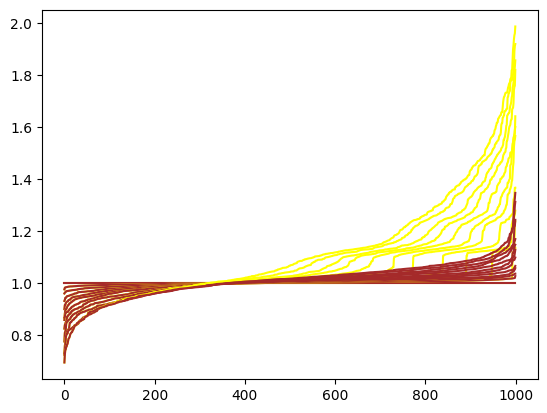

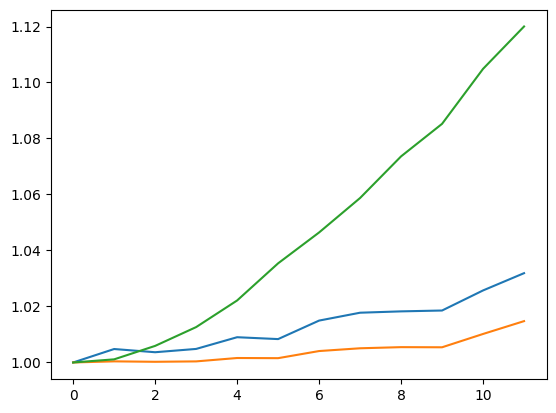

In [19]:
mlist = []
for i,y in enumerate(base_trader_yield_list):
    
    mlist.append([numpy.mean(asset_yield_list[i]), numpy.mean(y), numpy.mean(s1_trader_yield_list[i])])
    # pyplot.plot(numpy.sort(y), color="red")
    # pyplot.plot(numpy.sort(asset_yield_list[i]), color="blue")
    pyplot.plot(numpy.sort(s1_trader_yield_list[i]), color="yellow")
    pyplot.plot(numpy.sort(s2_trader_yield_list[i]), color="brown")
pyplot.show()

marray = numpy.array(mlist)
pyplot.plot(marray[:,0], label="spot")
pyplot.plot(marray[:,1], label="trader")
pyplot.plot(marray[:,2], label="s1")
pyplot.show()

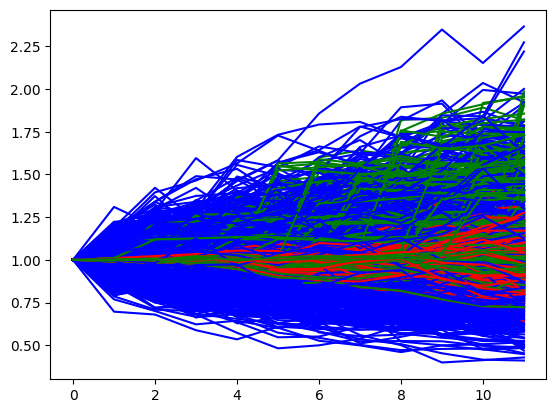

In [20]:
for i in range(1000):
    pyplot.plot([k[i] for k in asset_yield_list], color="blue")
    pyplot.plot([k[i] for k in base_trader_yield_list], color="red")
    pyplot.plot([k[i] for k in s1_trader_yield_list], color="green")
pyplot.show()

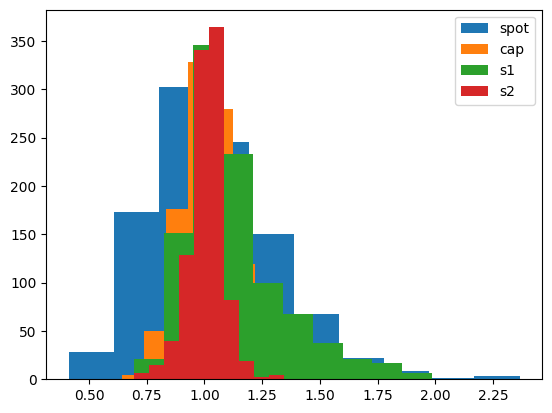

In [21]:
pyplot.hist(asset_yield_list[-1], label="spot")
pyplot.hist(base_trader_yield_list[-1], label="cap")
pyplot.hist(s1_trader_yield_list[-1], label="s1")
pyplot.hist(s2_trader_yield_list[-1], label="s2")
pyplot.legend()
pyplot.show()